In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam, lr_scheduler

from utils import get_device, f1_score_function
from sklearn.metrics import accuracy_score

## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskB_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,topic,conspiracy
0,0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon,1
1,1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid,0
2,2,L'avete capito che non toglieranno il green pa...,Covid,0
3,3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta,3
4,4,"In breve tempo, per accedere a Internet, sarà ...",Qanon,1


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            810 non-null    int64 
 1   comment_text  810 non-null    object
 2   topic         810 non-null    object
 3   conspiracy    810 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.4+ KB


0 is Covid-Conspiracy,

1 is Qanon-Conspiracy,

2 is Flat Earth-Conspiracy,

3 is Pro-Russia Conspiracy.

0    435
1    242
3     76
2     57
Name: conspiracy, dtype: int64


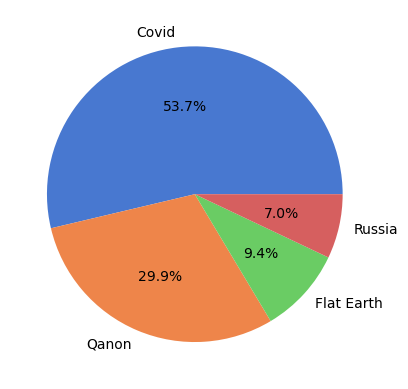

In [5]:
print(texts_df.conspiracy.value_counts())

palette = sns.color_palette('muted')
topic_labels = ['Covid', 'Qanon', 'Flat Earth', 'Russia']
plt.pie(texts_df.conspiracy.value_counts(), labels=topic_labels, autopct='%1.1f%%', colors=palette)
plt.show()

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskB_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,Ho fatto delle foto aeree ad una quota di circ...
1,1,Prof. Bellavite: tantissime persone costrette ...
2,2,"Ma si allontana.... su una terra PIATTA,......"
3,3,Non tutti gli Ukraini sono contro la Russia.\n...
4,4,Non opinioni ma dati.\n\nUno strepitoso **Giov...


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            300 non-null    int64 
 1   comment_text  300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


## Preprocessing

Remove break line characthers

In [8]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))


## Train-Validation split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [10]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiracy):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [11]:
print(train_df.info())
print(train_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 34 to 376
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            648 non-null    int64 
 1   comment_text  648 non-null    object
 2   topic         648 non-null    object
 3   conspiracy    648 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.3+ KB
None
0    348
1    193
3     61
2     46
Name: conspiracy, dtype: int64


In [12]:
print(val_df.info())
print(val_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 396 to 694
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            162 non-null    int64 
 1   comment_text  162 non-null    object
 2   topic         162 non-null    object
 3   conspiracy    162 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ KB
None
0    87
1    49
3    15
2    11
Name: conspiracy, dtype: int64


## Tokenization

In [13]:
from transformers import LlamaTokenizer

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
tokenizer = LlamaTokenizer.from_pretrained('/home/giacomo/Ai/llama/hgf_weights')

In [15]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiracy'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiracy'].to_numpy()

texts_test = texts_df_test['comment_text']

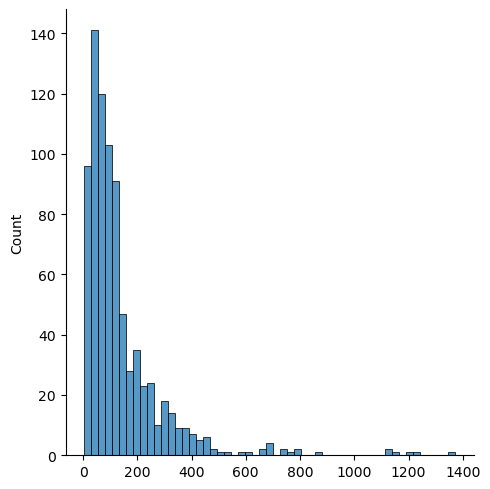

In [16]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

Llama max token length is 2048.

In [17]:
input_ids_tr, input_ids_val, input_ids_test = [], [], []

for sentence in texts_tr:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_tr.append(tokenized)

for sentence in texts_val:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_val.append(tokenized)

for sentence in texts_test:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_test.append(tokenized)

## Llama model

In [18]:
from transformers import LlamaModelsubtaskB

model = LlamaModel.from_pretrained('/home/giacomo/Ai/llama/hgf_weights')

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]
Some weights of the model checkpoint at /home/giacomo/Ai/llama/hgf_weights were not used when initializing LlamaModel: ['lm_head.weight']
- This IS expected if you are initializing LlamaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
llama_embeddings_tr, llama_embeddings_val, llama_embeddings_test = [], [], []

llama_embed_folder_pth = 'llama_embeddings'
if not os.path.exists(llama_embed_folder_pth):
    os.makedirs(llama_embed_folder_pth)

Get and save Llama embeddings for traning, validation and test sets.

In [20]:
for input_ids in tqdm(input_ids_tr):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_tr.append(last_hidden_states[0][:, -1, :].numpy())


# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_tr.npy'), llama_embeddings_tr)

100%|██████████| 648/648 [1:03:22<00:00,  5.87s/it]


In [20]:
for input_ids in tqdm(input_ids_val):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_val.append(last_hidden_states[0][:, -1, :].numpy())

# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_val.npy'), llama_embeddings_val)

100%|██████████| 162/162 [15:41<00:00,  5.81s/it]


In [20]:
for input_ids in tqdm(input_ids_test):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_test.append(last_hidden_states[0][:, -1, :].numpy())

# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_test.npy'), llama_embeddings_test)

100%|██████████| 300/300 [26:30<00:00,  5.30s/it]


# NN classifier on Llama embeddings

### Generate Dataloaders

In [21]:
labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

In [22]:
llama_embeddings_tr = torch.tensor(np.squeeze(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_tr.npy'))))
llama_embeddings_val = torch.tensor(np.squeeze(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_val.npy'))))
llama_embeddings_test = torch.tensor(np.squeeze(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_test.npy'))))

In [23]:
print(llama_embeddings_tr.shape)
print(llama_embeddings_val.shape)
print(llama_embeddings_test.shape)

torch.Size([648, 4096])
torch.Size([162, 4096])
torch.Size([300, 4096])


In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [25]:
print(llama_embeddings_test.size())

torch.Size([300, 4096])


Wrap data into a TensorDataset

In [26]:
tr_dataset = TensorDataset(llama_embeddings_tr, labels_tr)
val_dataset = TensorDataset(llama_embeddings_val, labels_val)
test_dataset = TensorDataset(llama_embeddings_test)

Create DataLoaders

In [27]:
batch_size = 32

tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

### NN Model

Model object and initialization function.

In [52]:
class LllamaEmbedsClf(nn.Module):
    def __init__(self, hidden_layers_dim=[2048, 64], layers_dropout=[0.3, 0.2],  *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Check if hidden_layers_dim and dropout_probs have the same length
        if len(hidden_layers_dim) != len(layers_dropout):
            raise ValueError('hidden_layers_dim and dropout_probs must have the same length')

        llama_hidden_dim = 4096

        # Dynamic hidden layers dim and dropput
        self.layers = nn.ModuleList()
        prev_dim = llama_hidden_dim
        for i, hidden_dim in enumerate(hidden_layers_dim):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(layers_dropout[i]))
            prev_dim = hidden_dim

        self.layers.append(nn.Linear(hidden_layers_dim[-1], 4))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
# Returns initialized model
def init_llama_embeds_clf(lr_rate=1e-5, gamma=0.9, hidden_layers_dim=[2048, 64], layers_dropout=[0.3, 0.2]):
    llama_embeds_clf = LllamaEmbedsClf(hidden_layers_dim=hidden_layers_dim, layers_dropout=layers_dropout)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = Adam(params = llama_embeds_clf.parameters(), lr=lr_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
    
    return llama_embeds_clf, loss_function, optimizer, scheduler

Train, validation and test functions whcih include loop over batches (for 1 epoch only).    

In [53]:
def train_clf(model, tr_dataloader, loss_function, optimizer, scheduler, device='cpu'):
    model.to(device)

    # Put the model into training mode
    model.train()

    loss_total = 0
    predictions, labels = [], []

    for step, batch in enumerate(tr_dataloader):
        # Load batch to GPU
        b_embeds = batch[0].to(device)
        b_labels = batch[1].to(device)

        # Zero out any previously calculated gradients
        model.zero_grad()

        # Perform a forward pass
        raw_preds = model(b_embeds)

        loss = loss_function(raw_preds, b_labels)
        loss_total += loss.item()

        # Discretize classes
        _, b_preds = torch.max(raw_preds, dim=1)

        # Perform a backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update optimizer and scheduler
        optimizer.step()
        scheduler.step()

        # Move preds and labels to CPU
        b_preds = b_preds.detach().cpu().tolist()
        b_labels = b_labels.detach().cpu().tolist()
        
        # Store predictions and true labels
        predictions += b_preds
        labels += b_labels

    # Calculate scores and avg loss
    acc_score = accuracy_score(labels, predictions)
    f1_score = f1_score_function(labels, predictions)
    avg_epoch_loss_tr = loss_total / len(tr_dataloader)  

    return avg_epoch_loss_tr, acc_score, f1_score, model, optimizer, scheduler

def eval_clf(model, eval_dataloader, loss_function, device='cpu'):
    # Put model into evaluation mode
    model.eval()

    loss_total = 0
    predictions, labels = [], []

    with torch.no_grad():
        for step, batch in enumerate(eval_dataloader):
            b_embeds, b_labels = tuple(t.to(device) for t in batch)
            
            # Perform a forward pass
            raw_preds = model(b_embeds)

            loss = loss_function(raw_preds, b_labels)
            loss_total += loss.item()
            
            # Discretize classes
            _, b_preds = torch.max(raw_preds, dim=1)

            # Move preds and labels to CPU
            b_preds = b_preds.detach().cpu().tolist()
            b_labels = b_labels.detach().cpu().tolist()
            
            # Store predictions and true labels
            predictions += b_preds
            labels += b_labels

    # Calculate scores and avg loss
    acc_score = accuracy_score(labels, predictions)
    f1_score = f1_score_function(labels, predictions)
    avg_epoch_loss_eval = loss_total / len(eval_dataloader)

    return avg_epoch_loss_eval, acc_score, f1_score, predictions, labels

def test_clf(model, test_dataloader, device='cpu'):
    # Put model into evaluation mode
    model.eval()

    predictions, raw = [], []

    with torch.no_grad():
        for step, batch in enumerate(test_dataloader):
            b_embeds = batch[0].to(device)
            
            # Perform a forward pass
            raw_preds = model(b_embeds)

            # Discretize classes
            _, b_preds = torch.max(raw_preds, dim=1)

            # Move preds to CPU
            b_preds = b_preds.detach().cpu().tolist()
            
            # Store predictions
            predictions += b_preds

    return predictions

### Grid search

Set save folder for this run

In [54]:
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_llama_subtaskB/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-05-02 23:51:29.842552


Define fixed hyperparams.

In [55]:
max_epochs = 20
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


Grid searched hyperparams.

In [56]:
lr_list = [1e-4, 3e-4, 5e-4, 8e-4, 1e-3]
gamma_list = [0.99, 0.999]
# 'layers' indicates each hidden layer's dimension, while 'dropout' indicates the dropout prob after corresponding hiddenlayer
layers_config_list = [
    {'layers': [4096, 128], 'dropout':[0.4, 0.2], 'name': '3_layers_M'},
    {'layers': [4096, 768, 64], 'dropout':[0.5, 0.3, 0.1], 'name': '4_layers_M'},
    {'layers': [8192, 1024, 128], 'dropout':[0.5, 0.3, 0.1], 'name': '4_layers_L'}
]

Execute grid search. Loop over epochs for each hyperparam combination.

In [57]:
num_trials = len(lr_list) * len(gamma_list) * len(layers_config_list)
print('Executing {} trials in grid search'.format(num_trials))

for lr in lr_list:
    for gamma in gamma_list:
        for layers_config in layers_config_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_gamma{}_layers_{}'.format(lr, gamma, layers_config['name'])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, gamma={}, layers={}'.format(lr, gamma, layers_config['name']))

            torch.cuda.empty_cache()
            #print(torch.cuda.memory_summary())

            # Initialize model
            llama_embeds_model, loss_function, optimizer, scheduler = init_llama_embeds_clf(
                lr_rate=lr, gamma=gamma, hidden_layers_dim=layers_config['layers'], layers_dropout=layers_config['dropout'])

            for epoch_i in range(max_epochs):
                print('Epoch: {}'.format(epoch_i))

                # Train
                avg_epoch_loss_tr, acc_score_tr, f1_score_tr, llama_embeds_model, optimizer, scheduler = train_clf(llama_embeds_model, tr_dataloader, loss_function, optimizer, scheduler, device)


                print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

                # Eval
                avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(llama_embeds_model, val_dataloader, loss_function, device)
                print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

                # Save
                model_save_pth = os.path.join(model_folder_pth, 'llama_clf_{}.pt'.format(epoch_i))
                torch.save({
                            'epoch': epoch_i,
                            'model_state_dict': llama_embeds_model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'schdeduler_state_dict': scheduler.state_dict(),
                            'tr_loss': avg_epoch_loss_tr,
                            'val_loss': avg_epoch_loss_val,
                            'tr_acc': acc_score_tr,
                            'val_acc': acc_score_val,
                            'tr_f1': f1_score_tr,
                            'val_f1': f1_score_val,
                            'val_preds': predictions
                            }, model_save_pth)

            torch.cuda.empty_cache()

Executing 30 trials in grid search

Executing model with lr=0.0001, gamma=0.99, layers=3_layers_M
Epoch: 0
TRAINING | Tr Loss: 1.0417411611193703 - Tr acc: 0.566358024691358 - Tr f1: 0.39189110098685664
EVALUATION | Val Loss: 0.9438273012638092 - Val acc: 0.5679012345679012 - Val f1: 0.23105481546189122
Epoch: 1
TRAINING | Tr Loss: 0.8496263367789132 - Tr acc: 0.6466049382716049 - Tr f1: 0.4990613156558573
EVALUATION | Val Loss: 0.9527227481206259 - Val acc: 0.7037037037037037 - Val f1: 0.5159303465150542
Epoch: 2
TRAINING | Tr Loss: 0.7283966938654581 - Tr acc: 0.7160493827160493 - Tr f1: 0.573880915117507
EVALUATION | Val Loss: 0.7946210900942484 - Val acc: 0.7283950617283951 - Val f1: 0.5218505098405914
Epoch: 3
TRAINING | Tr Loss: 0.6153954239118666 - Tr acc: 0.7515432098765432 - Tr f1: 0.6289725069897483
EVALUATION | Val Loss: 0.6790527999401093 - Val acc: 0.7716049382716049 - Val f1: 0.6707247378523417
Epoch: 4
TRAINING | Tr Loss: 0.5494600534439087 - Tr acc: 0.779320987654321 - 

## Analyze grid search results

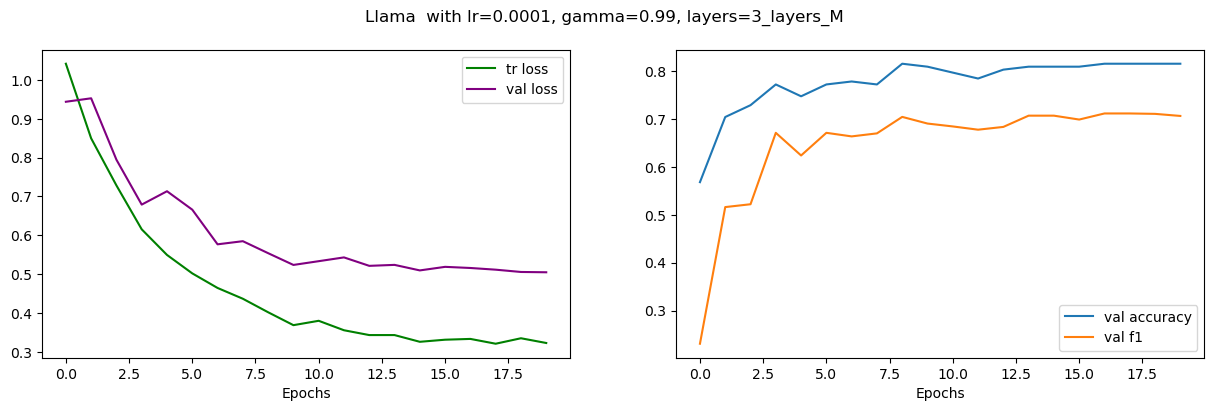

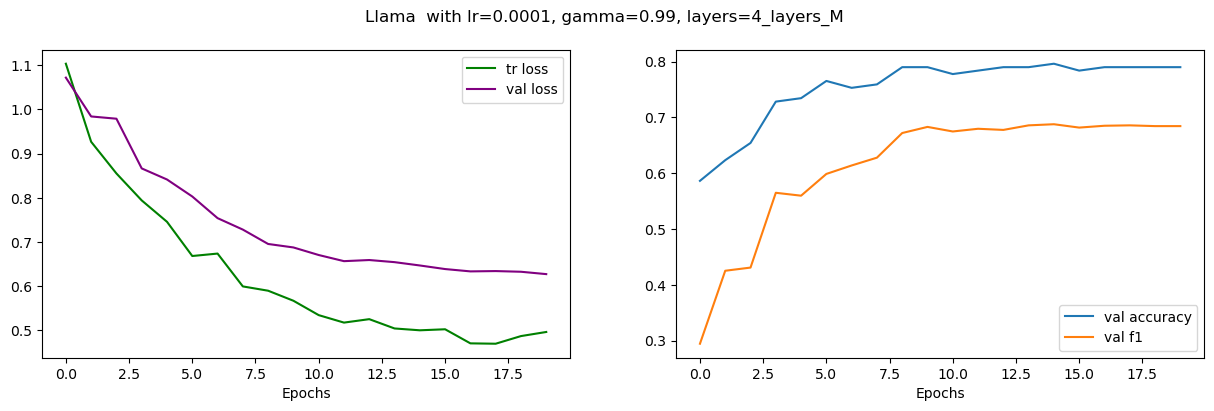

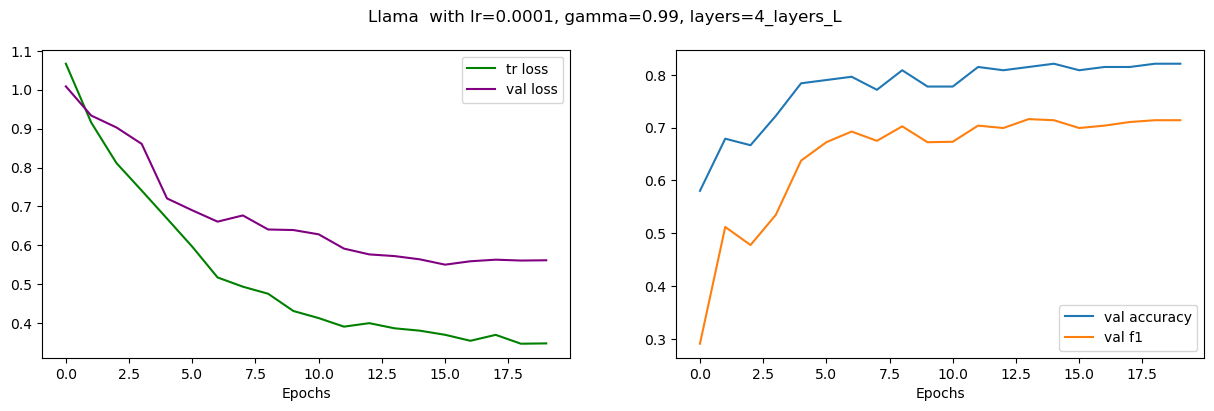

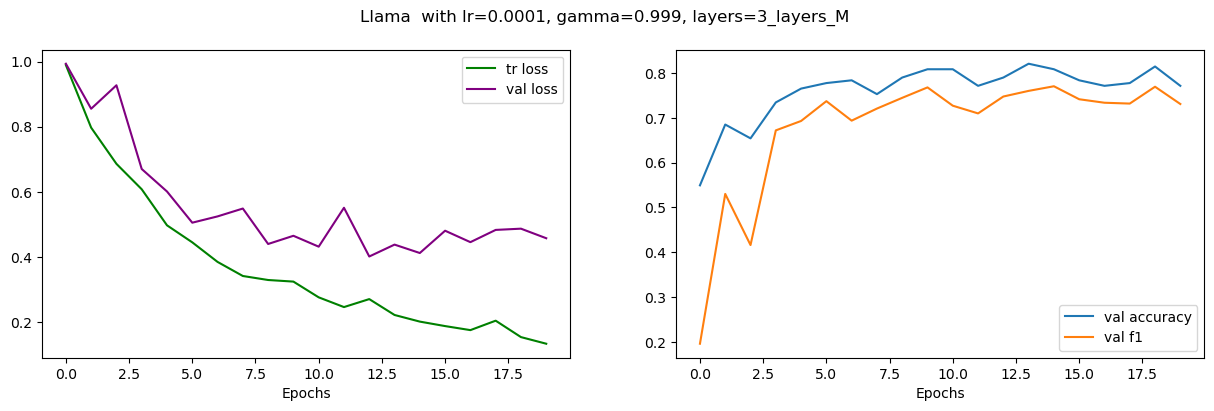

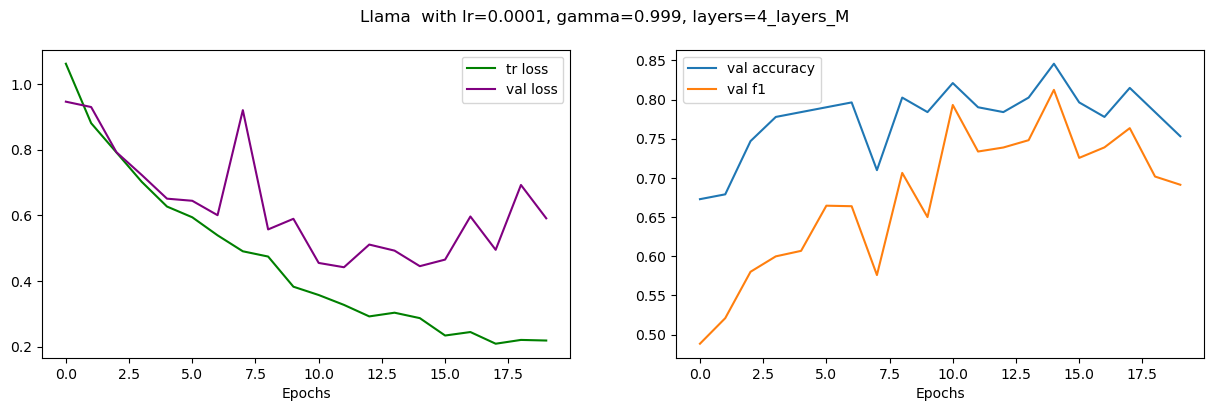

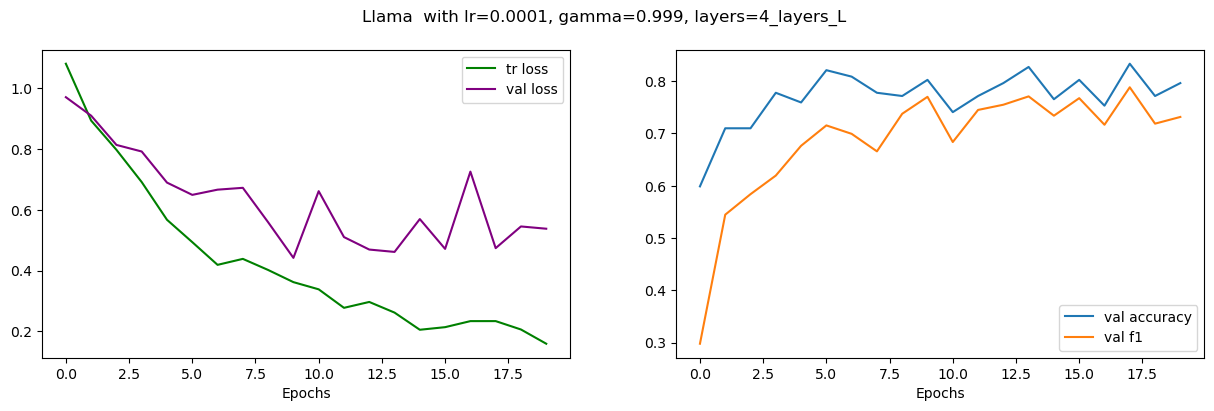

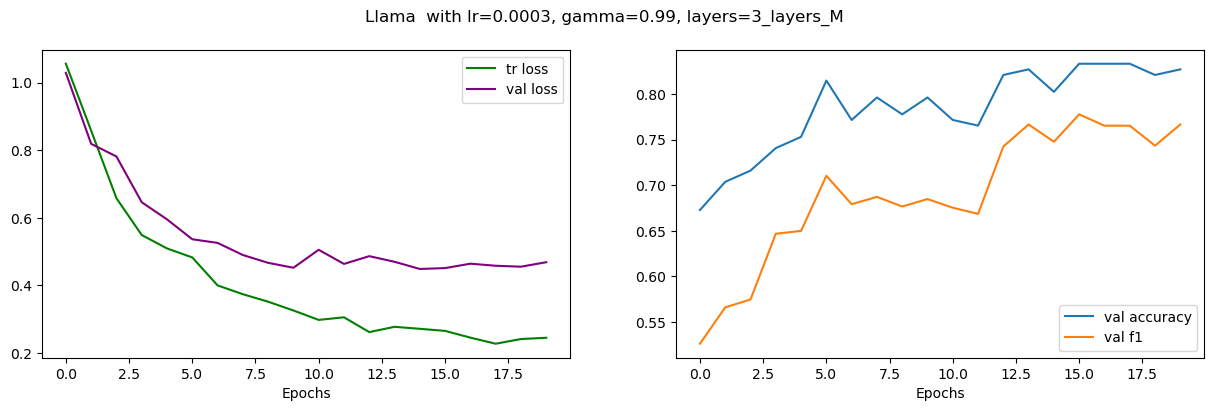

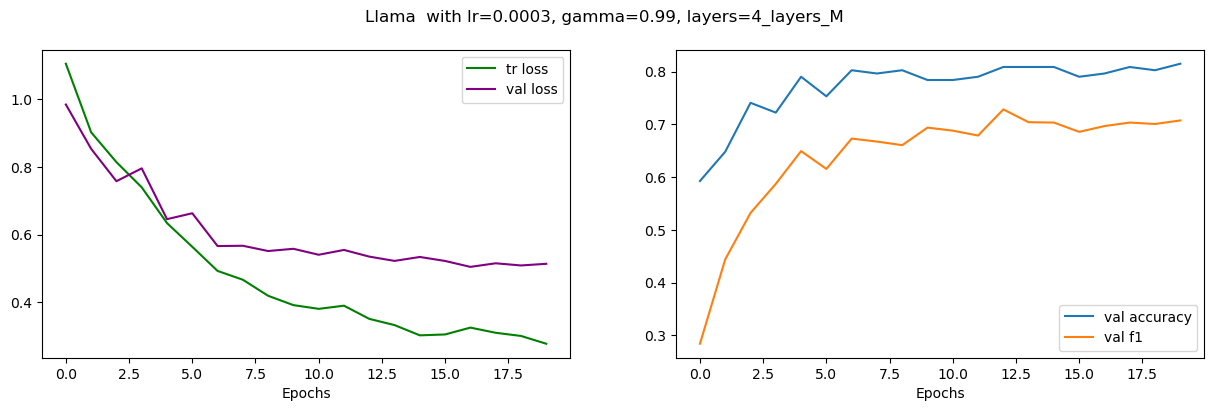

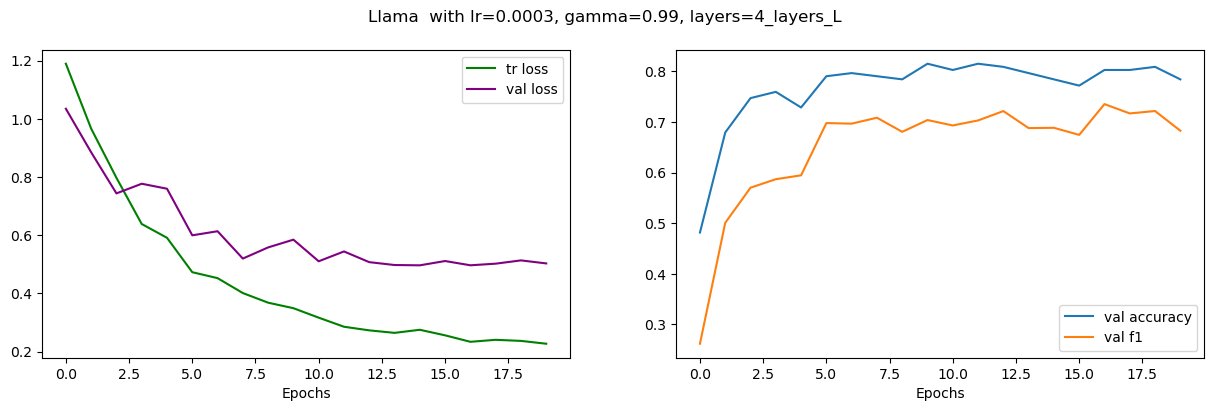

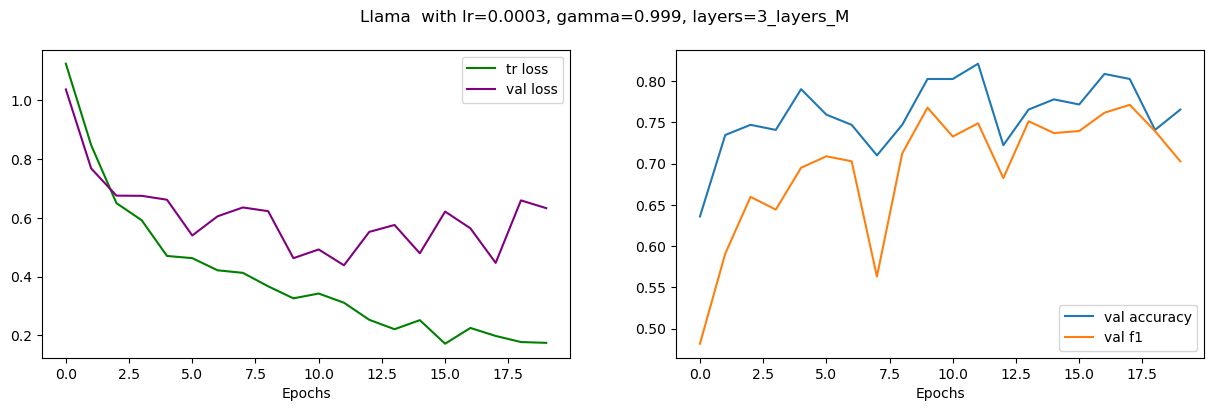

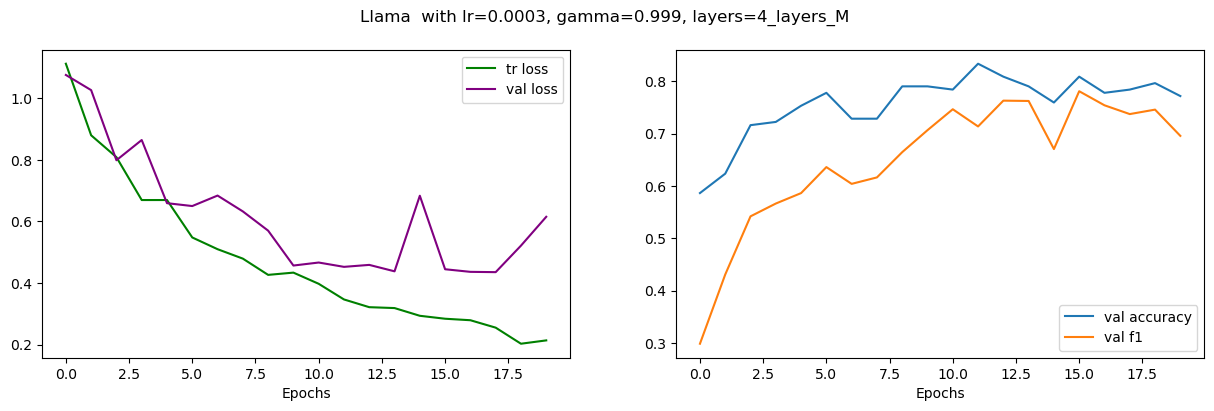

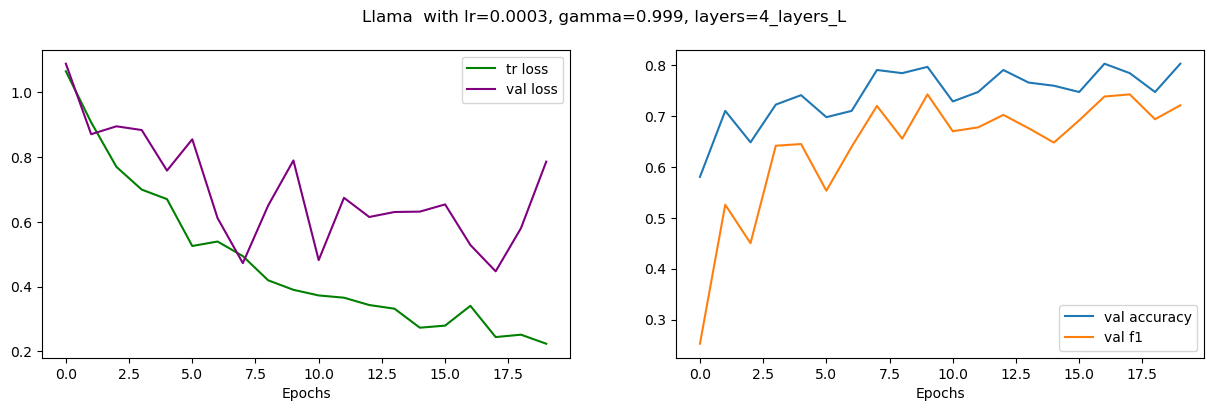

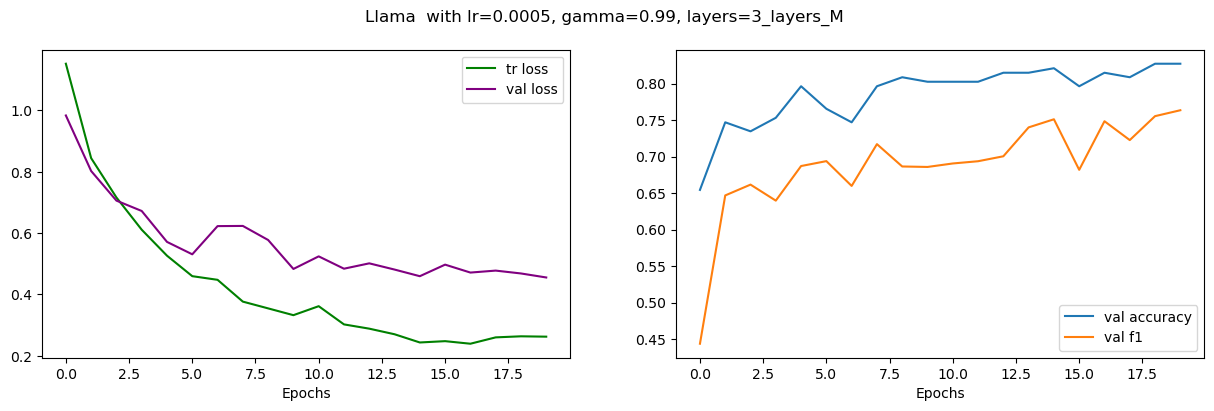

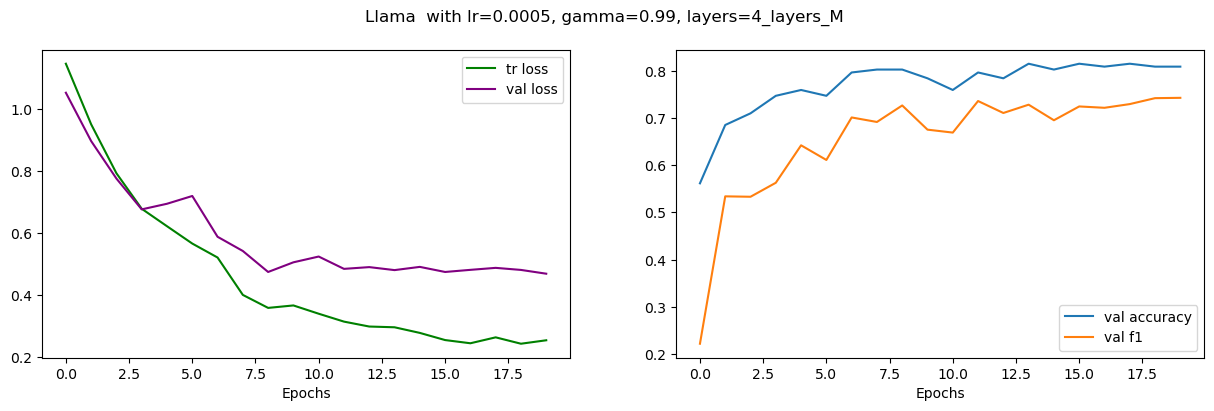

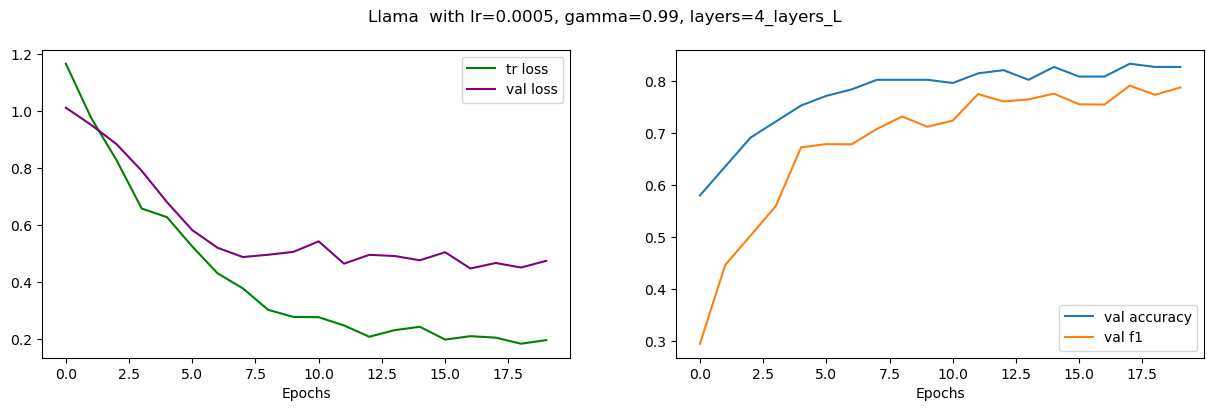

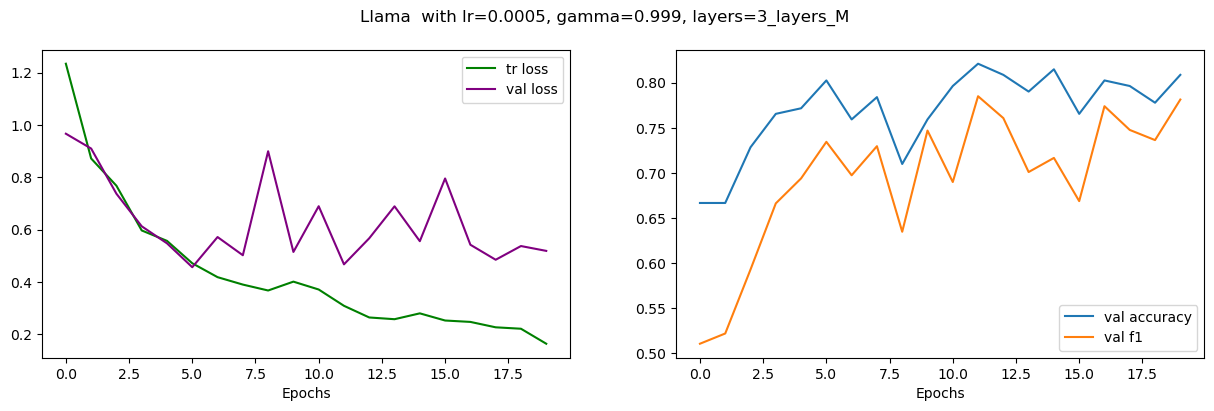

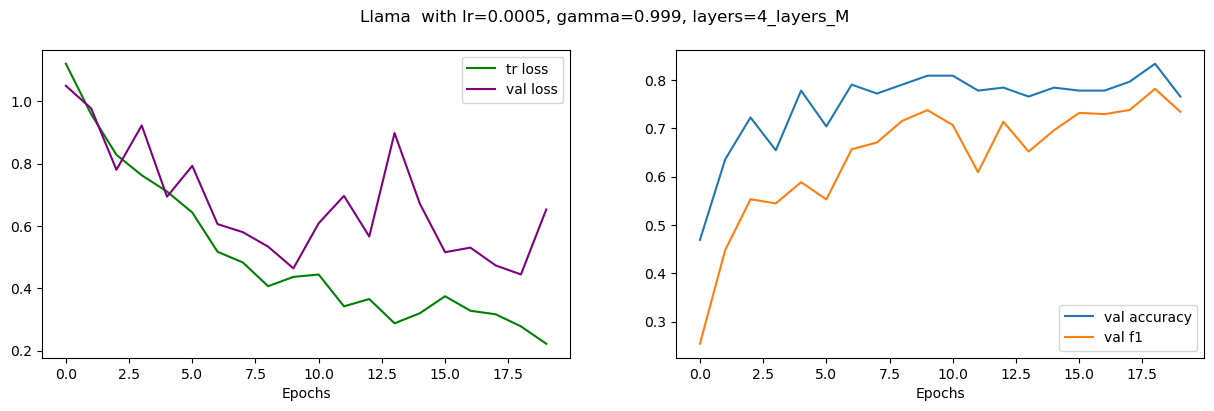

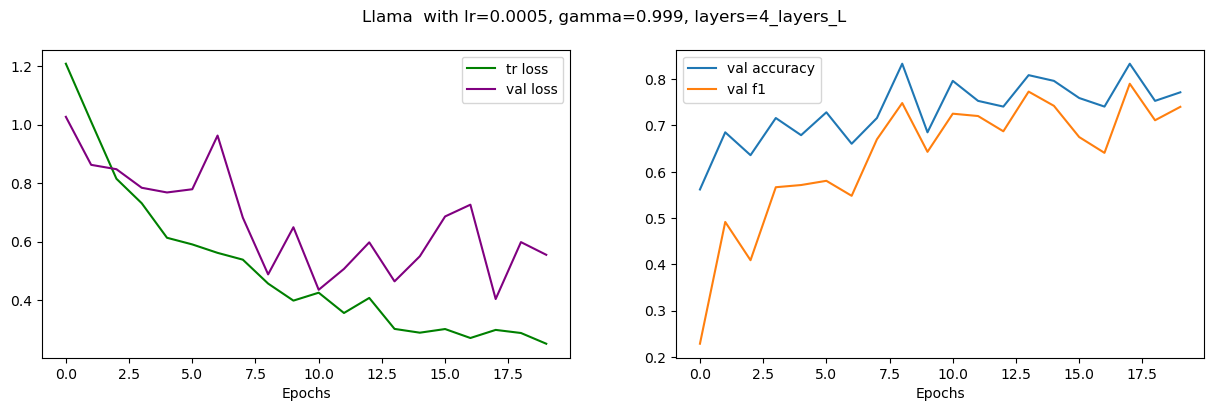

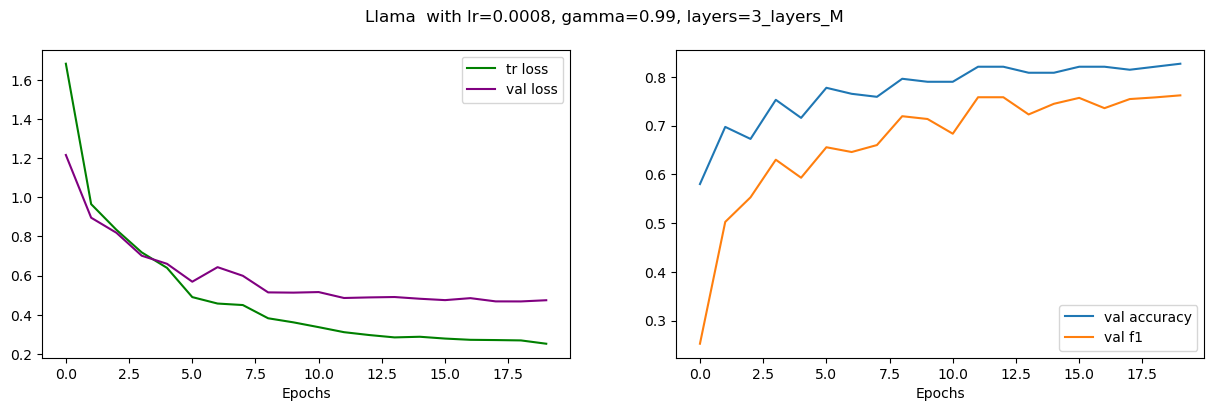

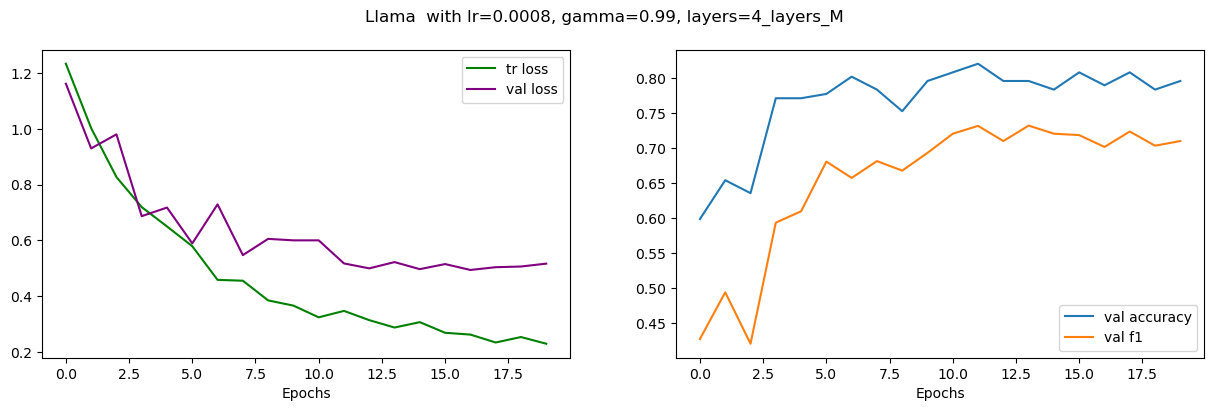

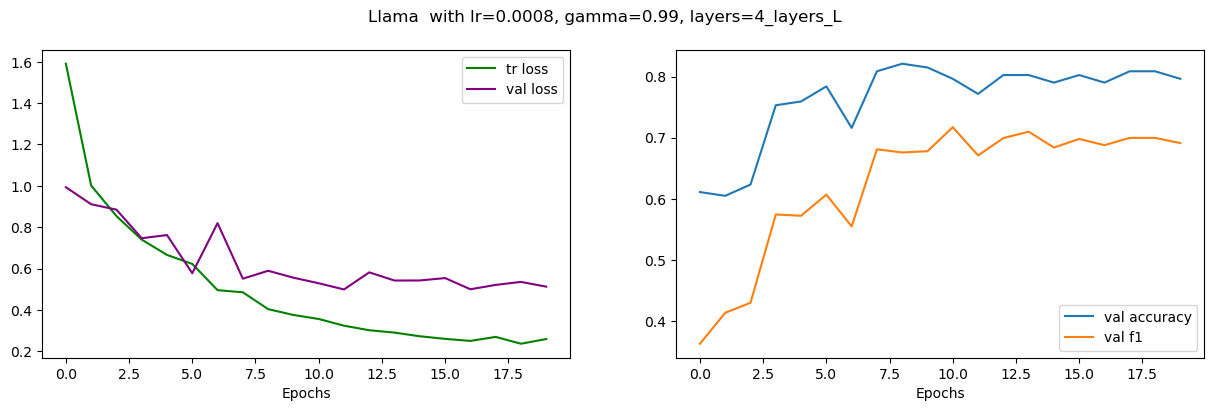

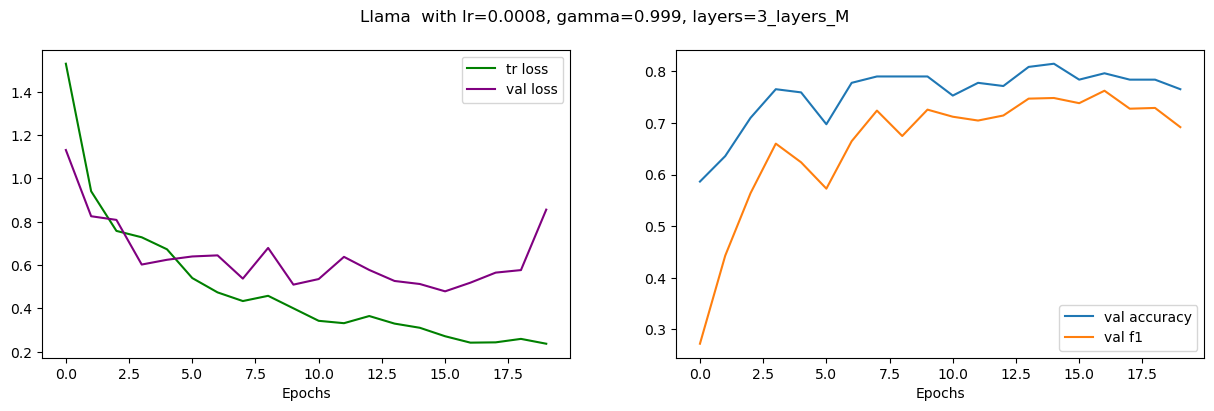

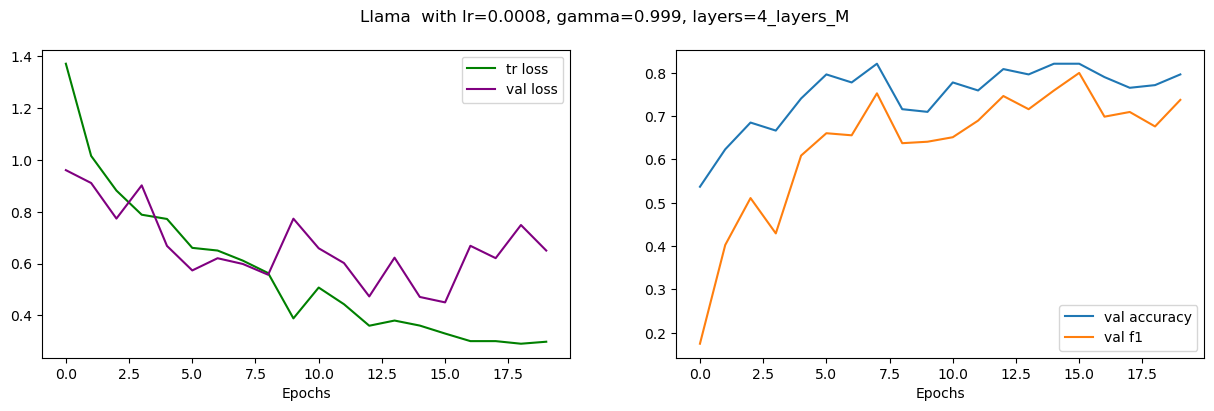

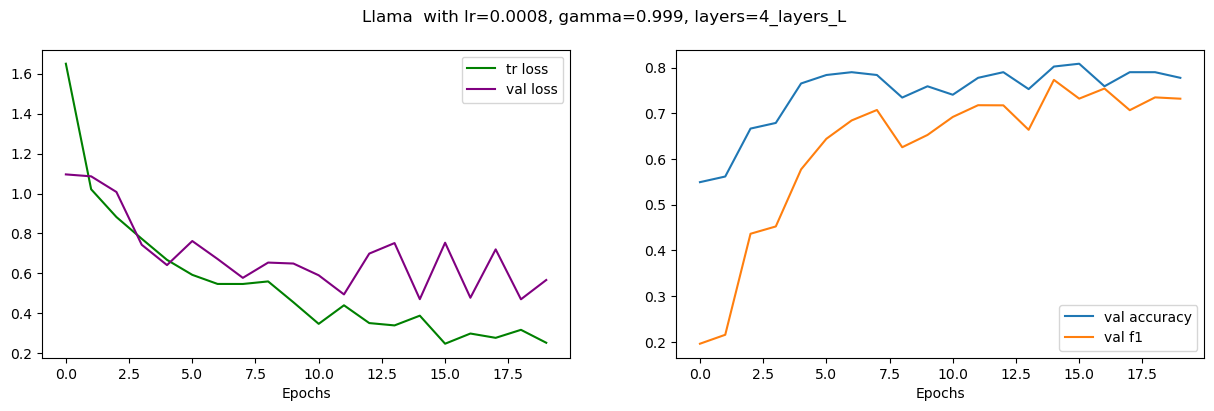

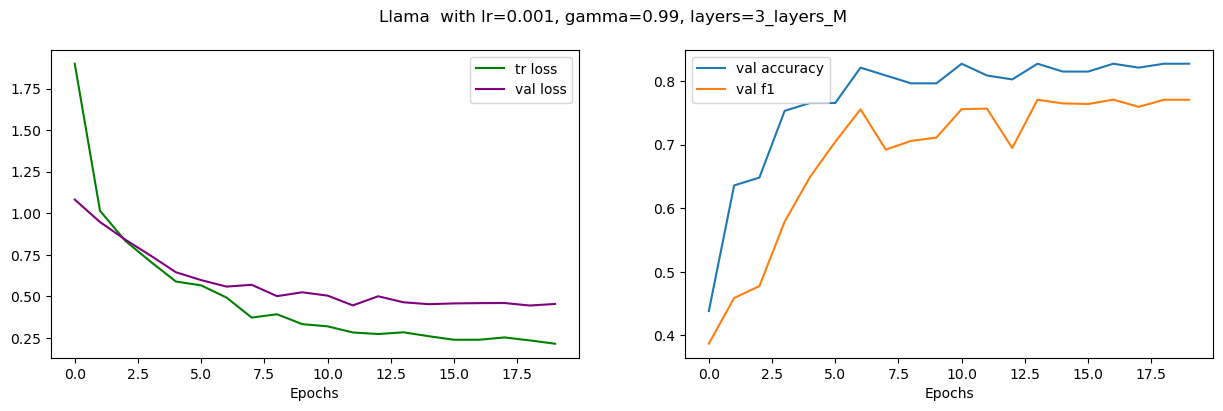

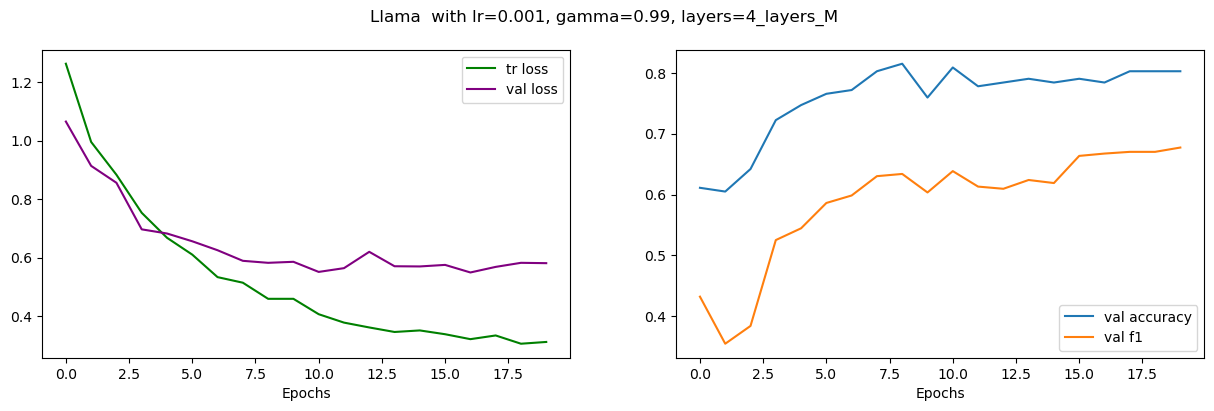

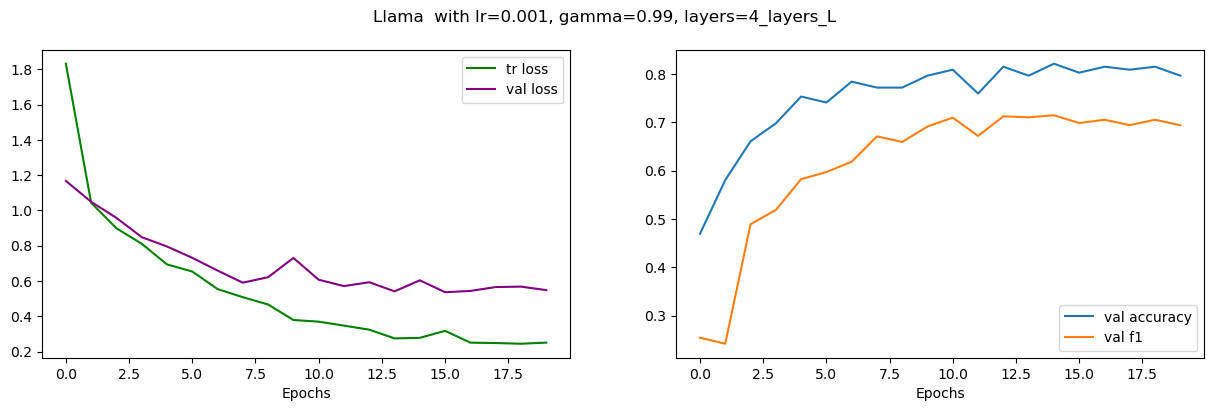

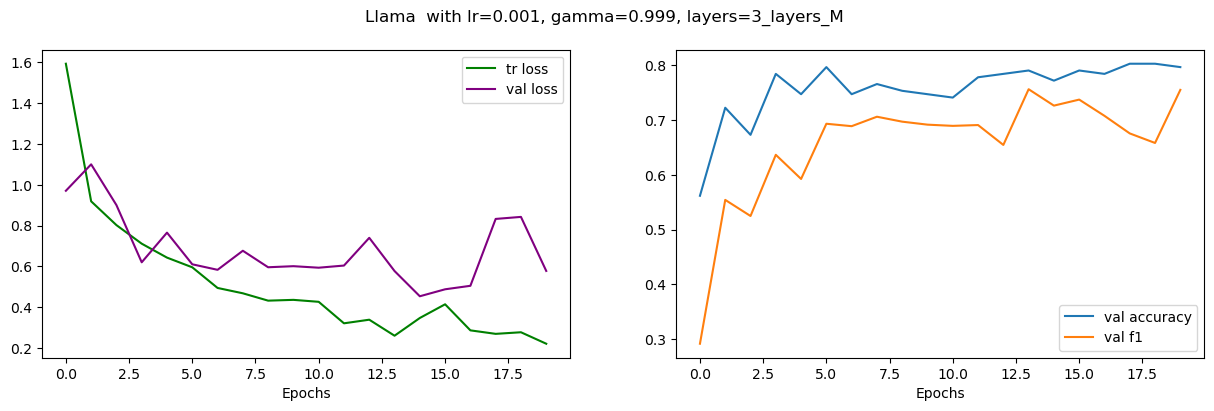

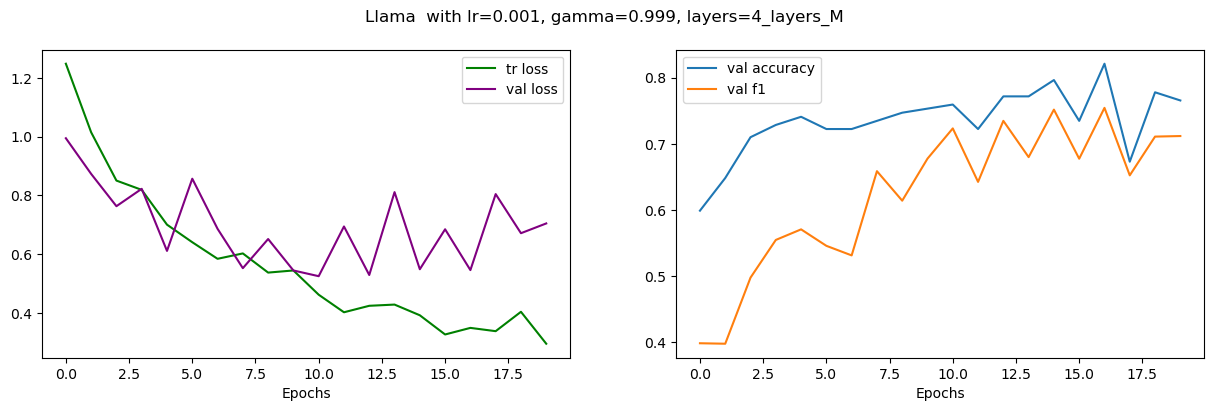

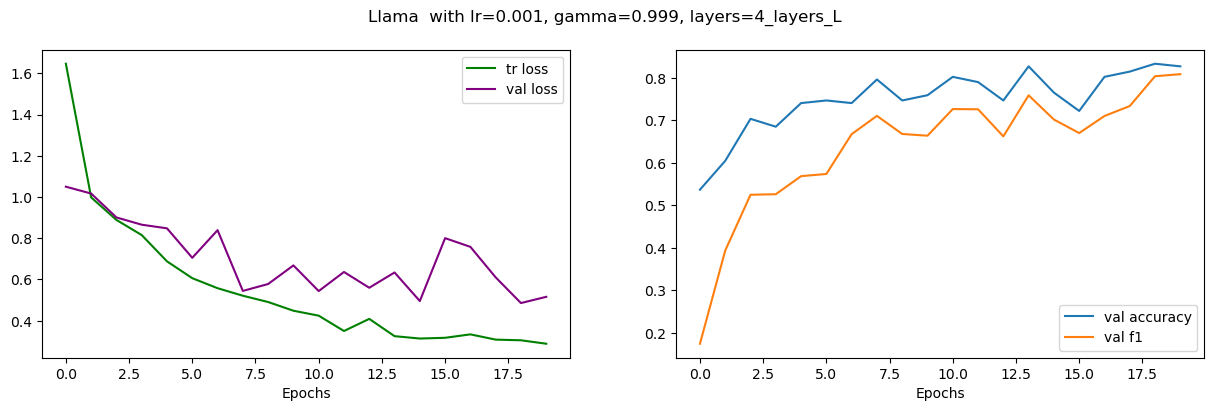

In [60]:
save_folder_pth = './checkpoints_llama_subtaskB/2_5_2023-23.51/' # Grid search run to analyze


best_f1_list = []

for lr in lr_list:
    for gamma in gamma_list:
        for layers_config in layers_config_list: 

            # Model path subfolder
            model_folder_str = 'lr{}_gamma{}_layers_{}'.format(lr, gamma, layers_config['name'])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'Llama  with lr={}, gamma={}, layers={}'.format(lr, gamma, layers_config['name'])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'llama_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()

In [61]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

Llama  with lr=0.0001, gamma=0.99, layers=3_layers_M at epoch 16, F1: 0.7111
Llama  with lr=0.0001, gamma=0.99, layers=4_layers_M at epoch 14, F1: 0.6879
Llama  with lr=0.0001, gamma=0.99, layers=4_layers_L at epoch 13, F1: 0.7161
Llama  with lr=0.0001, gamma=0.999, layers=3_layers_M at epoch 14, F1: 0.7707
Llama  with lr=0.0001, gamma=0.999, layers=4_layers_M at epoch 14, F1: 0.8123
Llama  with lr=0.0001, gamma=0.999, layers=4_layers_L at epoch 17, F1: 0.7883
Llama  with lr=0.0003, gamma=0.99, layers=3_layers_M at epoch 15, F1: 0.7778
Llama  with lr=0.0003, gamma=0.99, layers=4_layers_M at epoch 12, F1: 0.7283
Llama  with lr=0.0003, gamma=0.99, layers=4_layers_L at epoch 16, F1: 0.7351
Llama  with lr=0.0003, gamma=0.999, layers=3_layers_M at epoch 17, F1: 0.7711
Llama  with lr=0.0003, gamma=0.999, layers=4_layers_M at epoch 15, F1: 0.7808
Llama  with lr=0.0003, gamma=0.999, layers=4_layers_L at epoch 17, F1: 0.7423
Llama  with lr=0.0005, gamma=0.99, layers=3_layers_M at epoch 19, F1: 

## Choose and predict on test with best model

Best model is: Llama  with lr=0.0001, gamma=0.999, layers=4_layers_M at epoch 14, F1: 0.8123


In [62]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [63]:
final_model_pth = './checkpoints_llama_subtaskB/2_5_2023-23.51/lr0.0001_gamma0.999_layers_4_layers_M/llama_clf_14.pt'

layers_config = {'layers': [4096, 768, 64], 'dropout':[0.5, 0.3, 0.1], 'name': '4_layers_M'}

llama_embeds_clf = LllamaEmbedsClf(hidden_layers_dim=layers_config['layers'], layers_dropout=layers_config['dropout'])

llama_embeds_clf.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

llama_embeds_clf.to(device)

# Prediction on test
test_preds = test_clf(llama_embeds_clf, test_dataloader, device)

In [64]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[3, 0, 3, 2, 0, 3, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 3, 1, 1, 3, 0, 2, 0, 1, 0, 0, 1, 0, 3, 3, 3, 1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 3, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 3, 0, 0, 0, 0, 1, 1, 3, 0, 1, 1, 3, 1, 0, 3, 0, 0, 0, 1, 2, 0, 1, 1, 3, 0, 1, 1, 1, 0, 1, 0, 0, 0, 3, 2, 1, 1, 0, 1, 0, 0, 3, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 3, 0, 3, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 3, 0, 1, 1, 0, 3, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 3, 3, 0, 1, 1, 3, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 1, 0, 3, 0, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 2, 1, 0, 1, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 1, 3, 0, 1, 3, 0]
(array([0, 1, 2, 3]), array([162,  82,  10,  46]))


Generate result CSV

In [66]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_llama_submissionB.csv', index=False)

**RESULTS FROM KAGGLE:**

-On the 50% available hidden test set it scores 0.75073  F1 macro averaged

-On the other 50% of the test set it scores 0.72704  F1 macro averaged

-On the whole test set it scores **0.738885** F1 macro averaged